In [828]:
# pip install --upgrade spacy

In [829]:
# !python -m spacy download en_core_web_md

In [830]:
# pip install podium-nlp

In [831]:
# pip install hdbscan

In [832]:
# pip install bertopic

In [833]:
# pip install emoji

In [834]:
# pip install wordsegment

In [835]:
# pip install ekphrasis -U

In [836]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe
from nltk.sentiment import SentimentIntensityAnalyzer
from copy import deepcopy
from nltk.tokenize.casual import TweetTokenizer
from time import time
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.segmenter import Segmenter
from gensim.models import CoherenceModel

import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji
import warnings
warnings.filterwarnings("ignore")

In [837]:
# from google.colab import drive
# drive.mount('/content/drive')

In [838]:
# %cd drive/MyDrive/datasets/

# Preprocessing

In [839]:
nlp = spacy.load("en_core_web_md")

In [840]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [841]:
df.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_test.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_replace.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)

## Getting clean text

In [842]:
tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
df_tmp = df['Tweet text'].apply(tokenizer.tokenize)
df_test_tmp = df_test['Tweet text'].apply(tokenizer.tokenize)

In [843]:
def emoji_counter(s):
    return len(emoji.emoji_lis(s))

df['emoji_count'] = df['Tweet text'].apply(emoji_counter)
df_test['emoji_count'] = df_test['Tweet text'].apply(emoji_counter)

In [844]:
# seg_eng = Segmenter(corpus="english") 
seg_tw = Segmenter(corpus="twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [845]:
def separate_hashtags(s):
    '''Removes the hashtag sign and segments the hashtag text.'''
    hashtags = []
    
    l = []
    for i, s_i in enumerate(s):
        if s_i.startswith('#'):
            tmp = tokenizer.tokenize(seg_tw.segment(s_i.replace('#', '')))
            l.extend(tmp)
        else:
            l.append(s_i)
    return l
            
df_tmp = df_tmp.apply(separate_hashtags)
df_test_tmp = df_test_tmp.apply(separate_hashtags)

In [846]:
def preprocess_words(s):
    '''
    Removes tags, emojis, links, smiley faces, | signs, stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][()PDO\/\]\[p|]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: emoji.is_emoji(w)
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)

    w2 = []
    for i, w in enumerate(s):
        if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
            continue

        elif is_hashtag(w):
            w_tmp = w.replace('#', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

        elif is_smiley(w):
            w_tmp = re.sub(smiley_regex, '', w)
            if w_tmp != '':
                lower_append(w_tmp, w2)

        else:
            w_tmp = w.replace('#', '')
            w_tmp = w_tmp.replace('|', '')
            w_tmp = w_tmp.replace('_', '')
            w_tmp = w_tmp.replace('...', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

    return ' '.join([i for i in w2 if len(i) > 2])

def lower_append(w, l):
    l.append(w.lower())

df['clean_text'] = df_tmp.apply(preprocess_words)
df_test['clean_text'] = df_test_tmp.apply(preprocess_words)

In [847]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [848]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [849]:
df_tmp2 = df['clean_text'].copy()

In [850]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

df['clean_text'] = df[['clean_text']].apply(remove_tuple_characters)
df_test['clean_text'] = df_test[['clean_text']].apply(remove_tuple_characters)

print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [851]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

df['lemmas'] = df[['clean_text']].apply(lemmatize)
df_test['lemmas'] = df_test[['clean_text']].apply(lemmatize)

In [852]:
print(df.shape)
df = df[df['lemmas'].apply(lambda x: len(x)) > 0]
print(df.shape)

(3817, 6)
(3795, 6)


In [853]:
df.head(15)

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma..."
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,..."
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]"
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here,"[episode, leave, die]"
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual..."
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas,"[old, footie, pajama]"
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...,"[happy, highway, break, light, light, like, ch..."
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day,"[4:30, open, beer, long, night, day]"
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...,"[think, support, guy, knock, daughter, rice, d..."
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day,"[allow, open, christmas, day]"


In [854]:
### baseline features ###
tokenizer2 = TweetTokenizer()
def word_counter(s):
    return len([x for x in tokenizer.tokenize(s)])

def char_counter(s):
    return len(s.replace(' ', ''))

def all_uppercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.isupper() and not x.startswith(("@", "#", "http"))])

def all_lowercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.islower() and not x.startswith(("@", "#", "http"))])

def capitalised_counter(s):
    return sum([i.istitle() for i in tokenizer2.tokenize(s)])

def digit_counter(s):
    return sum([i.isdigit() for i in s])



### twitter related and punctuation features ###
def tag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("@")])

def hashtag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("#")])

def link_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith(('http:', 'https:'))])

def smiley_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if re.match(r'([\:\;\=][()PDO\/\]\[p|]+)+', x)])

def exclamation_mark_counter(s):
    return s.count('!')

def question_mark_counter(s):
    return s.count('?')

def ellipsis_counter(s):
    return s.count('...')
    


### NER features ###
def ORG_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'ORG'])

def NORP_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'NORP'])

def GPE_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'GPE'])

def PERSON_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'PERSON'])

In [855]:
def add_features(some_df):
    some_df['word_count'] = some_df['clean_text'].apply(word_counter)
    some_df['char_count'] = some_df['clean_text'].apply(char_counter)
    some_df['all_uppercase_count'] = some_df['Tweet text'].apply(all_uppercase_counter)
    some_df['all_lowercase_count'] = some_df['Tweet text'].apply(all_lowercase_counter)
    some_df['capitalised_count'] = some_df['Tweet text'].apply(capitalised_counter)
    some_df['digit_count'] = some_df['Tweet text'].apply(digit_counter)
    
    some_df['tag_count'] = some_df['Tweet text'].apply(tag_counter)
    some_df['hashtag_count'] = some_df['Tweet text'].apply(hashtag_counter)
    some_df['link_count'] = some_df['Tweet text'].apply(link_counter)
    some_df['smiley_count'] = some_df['Tweet text'].apply(smiley_counter)
    
    some_df['exclamation_mark_count'] = some_df['Tweet text'].apply(exclamation_mark_counter)
    some_df['question_mark_count'] = some_df['Tweet text'].apply(question_mark_counter)
    some_df['ellipsis_count'] = some_df['Tweet text'].apply(ellipsis_counter)
    
    some_df['ORG_tag_count'] = some_df['Tweet text'].apply(ORG_tag_counter)
    some_df['NORP_tag_count'] = some_df['Tweet text'].apply(NORP_tag_counter)
    some_df['GPE_tag_count'] = some_df['Tweet text'].apply(GPE_tag_counter)
    some_df['PERSON_tag_count'] = some_df['Tweet text'].apply(PERSON_tag_counter)
    
add_features(df)
add_features(df_test)

In [856]:
df.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma...",10,58,0,4,...,2,1,0,0,0,0,1,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,...",15,78,0,14,...,0,0,1,0,0,2,0,0,0,2
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]",8,40,1,4,...,0,0,0,1,0,0,0,0,1,0
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here,"[episode, leave, die]",6,28,0,5,...,0,0,0,0,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual...",16,88,1,20,...,0,0,0,1,0,0,1,0,0,0


In [857]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [858]:
df_train.reset_index(inplace=True, drop=True)
df_validation.reset_index(inplace=True, drop=True)

In [859]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,1,0,0,0,0,0,0,0,0,0
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,0,0,0,3,0,0,0,0,0,0
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,0,0,0,0,0,0,1,0,0,0
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,1,0,0,0,0,0,2,0,0,0
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,3,0,0,1,1,0,0,0,0,0


In [860]:
def new_df_with_all_features(df1, df2):
    cols_to_add = list(set(df2.columns.tolist()) - set(df1.columns.tolist()))
    if 'Tweet index' in cols_to_add:
        cols_to_add.remove('Tweet index')
    new_df = pd.concat((df1.copy(), df2[cols_to_add]), axis=1)
    return new_df

In [861]:
def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return ' '.join(s)

df_train['topic_text'] = df_train['lemmas'].apply(join_docs)
df_validation['topic_text'] = df_validation['lemmas'].apply(join_docs)
df_test['topic_text'] = df_test['lemmas'].apply(join_docs)

In [862]:
df_train.shape

(2656, 24)

In [863]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count,topic_text
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,0,0,0,0,0,0,0,0,0,course day monsoon outside class love life
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,0,0,3,0,0,0,0,0,0,district line major signal failure delay fanta...
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,0,0,0,0,0,1,0,0,0,receive email heir nigerian petroleum corporat...
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,0,0,0,0,0,2,0,0,0,programmer operation money power know
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,0,0,1,1,0,0,0,0,0,ironic song come ipod song selena gomez justin...


In [864]:
df_validation

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count,topic_text
0,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,...",15,78,0,14,...,0,1,0,0,2,0,0,0,2,rumor talk erv agent angel ask escobar hardly
1,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual...",16,88,1,20,...,0,0,1,0,0,1,0,0,0,breathe choose notable quote year annual list ...
2,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas,"[old, footie, pajama]",7,33,0,4,...,1,0,0,0,0,1,0,0,1,old footie pajama
3,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day,"[allow, open, christmas, day]",9,41,0,8,...,0,0,1,0,0,0,0,0,0,allow open christmas day
4,14,0,Cold or warmth both suffuse one's cheeks with ...,0,cold warmth both suffuse one's cheeks with pin...,"[cold, warmth, suffuse, cheek, pink, colour, t...",17,96,0,17,...,0,0,0,1,1,0,0,0,0,cold warmth suffuse cheek pink colour tone und...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,3812,1,The world is such a smiley place. 😳 \r,1,the world such smiley place,"[world, smiley, place]",5,23,0,6,...,0,0,0,0,0,0,0,0,0,world smiley place
1135,3815,0,I would have made a much more convincing Bella...,0,would have made much more convincing bella swan,"[convincing, bella, swan]",8,40,1,7,...,0,0,0,0,0,0,0,0,1,convincing bella swan
1136,3830,0,@banditelli regarding what the PSU president d...,0,regarding what the psu president does,"[regard, psu, president]",6,32,1,5,...,0,0,0,0,0,0,0,0,0,regard psu president
1137,3832,0,well now that i've listened to all of into the...,0,well now that i've listened all into the woods...,"[listen, wood, listen, fob, surprise]",16,72,1,17,...,0,0,0,0,0,1,0,0,0,listen wood listen fob surprise


## Topic modeling baselines

In [865]:
count_vectorizer = CountVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tweet_text_count_train = count_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_count_validation = count_vectorizer.transform(df_validation['topic_text'])
tweet_text_count_test = count_vectorizer.transform(df_test['topic_text'])

tweet_text_tfidf_train = tfidf_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_tfidf_validation = tfidf_vectorizer.transform(df_validation['topic_text'])
tweet_text_tfidf_test = tfidf_vectorizer.transform(df_test['topic_text'])

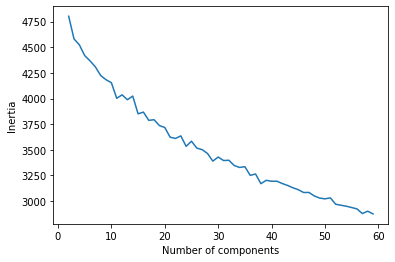

In [866]:
inertia = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [1046]:
model = KMeans(17)
model.fit(tweet_text_count_train)

kmeans_count_labels_train = model.predict(tweet_text_count_train)
kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
kmeans_count_labels_test = model.predict(tweet_text_count_test)

In [1047]:
from sklearn.metrics import silhouette_score

def evaluate_cluster(model, X_val, y_val, X_test, y_test):
    print(f'Validation silhouette score: {silhouette_score(X_val, y_val)}')
    print(f'      Test silhouette score: {silhouette_score(X_test, y_test)}')
    print(f'                   Inertia : {model.inertia_}')

evaluate_cluster(
    model,
    tweet_text_count_validation, 
    kmeans_count_labels_validation, 
    tweet_text_count_test, 
    kmeans_count_labels_test
)

Validation silhouette score: 0.20300011850171504
      Test silhouette score: 0.17148838994464605
                   Inertia : 3770.2894818715085


In [1048]:
occurences = {i:0 for i in range(max(kmeans_count_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_count_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_count_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

@ZozeeBo:The stuff press write about it literally ridiculous!Would it be harsh to point out the lack of literacy here? #ghostwriter 
My boy has another cold and spent the night coughing and sneezing all over me #sexy 
#RedSox RT @pgammo: Meanwhile, in Caguas, Rusney Castillo goes 4-5 with mammoth HR. man, Alex Cora loves this guy

@Giants ooooo touching myself to ODB he is the greatest Giants player to ever play the game... Screw that the best player ever!! 
@Owain_Thomas Loving how Fulham looks like a playoff team. #NotReally 
Is it ironic for a @selenagomez song to come on my #ipod after a @justinbieber song?!  #SelenaGomez #JustinBeiber

Don't give up what you want most for what you want now. #inspiration #motivationalquotes #startup
Buddhism Chant (kids) https://t.co/prrr8wRhoL #Music #Education
#RedSox RT @pgammo: Meanwhile, in Caguas, Rusney Castillo goes 4-5 with mammoth HR. man, Alex Cora loves this guy



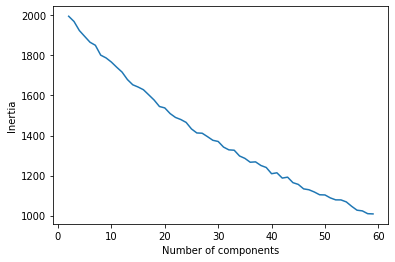

In [870]:
inertia = []
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [1049]:
model = KMeans(17)
model.fit(tweet_text_tfidf_train)

kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

In [1050]:
evaluate_cluster(
    model,
    tweet_text_tfidf_validation, 
    kmeans_tfidf_labels_validation, 
    tweet_text_tfidf_test, 
    kmeans_tfidf_labels_test
)

Validation silhouette score: 0.20195669785901554
      Test silhouette score: 0.18097755895530568
                   Inertia : 1588.7346494898122


In [1051]:
occurences = {i:0 for i in range(max(kmeans_tfidf_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_tfidf_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_tfidf_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

@highfivelife7 why are you so beautiful?!
Amen, that's due to them  having respect for themselves. http://t.co/vWIPkscXzV
Fun at @JRfm #Basics4Babies Day @langleyevents on Sunday: Ask Travis Lulay to get his face painted like Tony The Tiger  #worthashot

Bummer ending... But what a fun game and season. #Gophers
@vincent_h3 At 2:30am? Who's gonna favourite it? An owl?
#BBC #News -- #Denmark #challenges #Russia and #Canada #over #North #Pole. http://t.co/toAn6TGXcl

@michelledean @AVAETC not playing out in the provinces like, oh, Mississippi. 
Fleury with 5 shut outs so far on the season. He's still not good though 
Event technology session is having Internet problems.   #HSC2024



### BERTopic

In [874]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [1021]:
docs = df_validation['topic_text'].values.tolist()

def calc_coherence(topic_model, topics, docs=docs):
    # Preprocess Documents
    documents = pd.DataFrame({
        "Document": docs,
        "ID": range(len(docs)),
        "Topic": topics}
    )
    
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    
    # Preprocess Documents
    cleaned_docs = topic_model._preprocess_text(docs)

    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [
        [words for words, _ in topic_model.get_topic(topic) if words != ''] 
    for topic in range(len(set(topics))-1)]
    
    # Evaluate
    cm = CoherenceModel(
        topics=topic_words, 
        texts=tokens, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='u_mass'
    )
    return cm.get_coherence()

In [1052]:
tmp = {}
start = time()
for i in range(5, 11, 1):
    for j in range(10, 61, 10):
        topic_model = BERTopic(top_n_words=i, min_topic_size=j)
        topic_model.fit(df_train['topic_text'])
        topics, probs = topic_model.transform(df_validation['topic_text'])
        c = calc_coherence(topic_model, topics)
        tmp[(i, j)] = (c, topic_model.get_topic_info()['Count'][0])
    print(f'finished for {i}')
end = time()
print(f'{end-start}s')

finished for 5
finished for 6
finished for 7
finished for 8
finished for 9
finished for 10
1277.0962088108063s


In [1064]:
[print(f'{i[1], i[0]}: {tmp[i]}') for i in sorted(tmp, key=tmp.get)]
print()

(10, 10): (-18.64663651176032, 1022)
(10, 8): (-18.5323287206461, 987)
(20, 10): (-18.40942891770524, 1214)
(10, 9): (-18.377496014661915, 1068)
(40, 10): (-18.36148798350238, 1417)
(20, 8): (-18.23497337914904, 1140)
(30, 10): (-18.14762431644602, 1250)
(20, 9): (-18.011167663274993, 1173)
(30, 9): (-17.928798571307006, 1226)
(20, 7): (-17.85314036651038, 1211)
(40, 9): (-17.61522017621366, 1244)
(10, 7): (-17.430007238309635, 1146)
(40, 7): (-17.385772932617712, 1416)
(50, 7): (-17.335843394109105, 1418)
(40, 5): (-17.333890179972826, 1296)
(30, 8): (-17.319784908909526, 1260)
(20, 6): (-17.317442506775727, 1152)
(40, 8): (-17.27762742414177, 1300)
(30, 7): (-17.184960748852706, 1266)
(50, 5): (-16.96287571843669, 1387)
(40, 6): (-16.854003260172192, 1429)
(50, 10): (-16.828050669127197, 1387)
(50, 8): (-16.801146734504886, 1430)
(30, 6): (-16.64034846677885, 1300)
(10, 5): (-16.612102183188583, 1043)
(20, 5): (-16.573580602192052, 1152)
(60, 7): (-16.535554943490954, 1269)
(30, 5): 

In [878]:
start = time()
topic_model = BERTopic(top_n_words=10, min_topic_size=20)
topics, probs = topic_model.fit_transform(df_train['topic_text'])

pred_train = topic_model.transform(df_train['topic_text'])
pred_validation = topic_model.transform(df_validation['topic_text'])
pred_test = topic_model.transform(df_test['topic_text'])
end = time()
print(f'{end-start}s')

52.717705488204956s


In [879]:
# probability_threshold = 0.07
# new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# np.unique(new_topics, return_counts=True)

In [880]:
# probability_threshold = 0.07
# new_topics_train = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# new_topics_validation = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_validation[1]]
# new_topics_test = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_test[1]]
# np.unique(new_topics_train, return_counts=True)

In [881]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1124,-1_work_love_day_like
1,0,221,0_black_police_obama_people
2,1,182,1_fan_game_play_player
3,2,161,2_lol_funny_know_think
4,3,116,3_study_school_class_final
5,4,103,4_sleep_wake_hour_bed
6,5,93,5_twitter_tweet_follow_social
7,6,79,6_christmas_gift_tree_santa
8,7,74,7_food_eat_turkey_drink
9,8,73,8_love_smile_relationship_girl


In [1038]:
topic_model.save('bertopic_model')

In [882]:
# df_train_bertopic = df_train.copy()
# df_validation_bertopic = df_validation.copy()
# df_test_bertopic = df_test.copy()

In [883]:
df_train['topic'] = pred_train[0]
df_validation['topic'] = pred_validation[0]
df_test['topic'] = pred_test[0]

In [1023]:
c_val = calc_coherence(topic_model, pred_validation[0])
c_test = calc_coherence(topic_model, pred_test[0], df_test['topic_text'].values.tolist())

print(f'Validation coherence score: {c_val}')
print(f'      Test coherence score: {c_test}')

Validation coherence score: -17.93584109779372
      Test coherence score: -18.27488478286084


In [884]:
# df_train_bertopic.head()

## Embedding

In [885]:
tweet_embedding_train = df_train[['topic_text', 'Label']]
tweet_embedding_validation = df_validation[['topic_text', 'Label']]
tweet_embedding_test = df_test[['topic_text', 'Label']]

In [886]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)
tweet_embedding_test.reset_index(drop=True, inplace=True)

In [887]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=20)

TWEET = Field('text', numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(df_train[['topic_text', 'Label']], fields)
validation = TabularDataset.from_pandas(df_validation[['topic_text', 'Label']], fields)
test = TabularDataset.from_pandas(df_test[['topic_text', 'Label']], fields)
train.finalize_fields()

glove = GloVe()
embeddings = glove.load_vocab(vocab)

train_batch = train.batch(add_padding=True)
validation_batch = validation.batch(add_padding=True)
test_batch = test.batch(add_padding=True)

In [888]:
train_batch['text'].astype(int)[0:5]

array([[ 0,  3,  0,  0,  0,  2, 13,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]])

In [889]:
tweet_train = embeddings[train_batch['text'].astype(int)]
tweet_validation = embeddings[validation_batch['text'].astype(int)]
tweet_test = embeddings[test_batch['text'].astype(int)]

# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_validation_mean = tweet_validation.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)

In [890]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
df_train = pd.merge(df_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_validation_mean_df = pd.DataFrame(tweet_validation_mean)
df_validation = pd.merge(df_validation, embeddings_validation_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
df_test = pd.merge(df_test, embeddings_test_mean_df, left_index=True, right_index=True)

In [891]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,290,291,292,293,294,295,296,297,298,299
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,0.096357,-0.250714,0.192439,-0.068097,0.206409,-1.090046,0.272614,1.016354,0.742677,-0.172305
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,0.244302,-0.346964,0.197666,-0.182251,0.104589,-0.876984,0.375417,0.927484,0.699389,-0.154152
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,0.365576,-0.441187,0.162786,-0.350376,-0.029453,-0.424687,0.475646,0.644885,0.469085,-0.102024
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,0.135188,-0.261075,0.228174,-0.028906,0.225808,-1.283278,0.266020,1.137804,0.876035,-0.172817
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,0.282280,-0.378609,0.187417,-0.248457,0.044161,-0.647607,0.401314,0.757234,0.573003,-0.110834


In [892]:
nltk.download('vader_lexicon') # if error run this

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [893]:
def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['topic_text']) > 0:
            doc = nlp(row['topic_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(deepcopy(current_neg))
            neg_word_count.append(deepcopy(len(current_neg)))
            pos_words.append(deepcopy(current_pos))
            pos_word_count.append(deepcopy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [894]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)
neg_words_test, neg_word_count_test, pos_words_test, pos_word_count_test = pos_neg_words(df_test, 0.2)

In [895]:
df_train['neg_word_count'] = neg_word_count_train
df_train['pos_word'] = pos_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['neg_word'] = neg_words_train

df_validation['neg_word_count'] = neg_word_count_val
df_validation['pos_word'] = pos_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['neg_word'] = neg_words_val

df_test['neg_word_count'] = neg_word_count_test
df_test['pos_word'] = pos_words_test
df_test['pos_word_count'] = pos_word_count_test
df_test['neg_word'] = neg_words_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,294,295,296,297,298,299,neg_word_count,pos_word,pos_word_count,neg_word
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,0.206409,-1.090046,0.272614,1.016354,0.742677,-0.172305,0,[love],1,[]
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,0.104589,-0.876984,0.375417,0.927484,0.699389,-0.154152,2,[fantastic],1,"[failure, delay]"
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,-0.029453,-0.424687,0.475646,0.644885,0.469085,-0.102024,0,[],0,[]
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,0.225808,-1.283278,0.266020,1.137804,0.876035,-0.172817,0,[],0,[]
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,0.044161,-0.647607,0.401314,0.757234,0.573003,-0.110834,0,[],0,[]


In [896]:
topic_dummies = []
for i in topic_model.get_topic_info()['Topic'].values:
    topic_dummies.append(f'{i}_topic')
    
topic_dummies

['-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic',
 '17_topic']

In [897]:
def get_dummies(some_df):
    dummies = pd.get_dummies(some_df['topic'])
    copy = dummies.copy()
    j = -1
    for i in dummies.columns.tolist():
        if i != j:
            copy.insert(loc=j+1, column=f'{j}', value=0)
            j += 1
        j += 1
    return copy

# df_train[topic_dummies] = pd.get_dummies(df_train['topic'])
# df_validation[topic_dummies] = pd.get_dummies(df_validation['topic'])
# df_test[topic_dummies] = pd.get_dummies(df_test['topic'])

df_train[topic_dummies] = get_dummies(df_train)
df_validation[topic_dummies] = get_dummies(df_validation)
df_test[topic_dummies] = get_dummies(df_test)
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,8_topic,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,0,0,0,0,0,0,0,0,0,0
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,0,1,0,0,0,0,0,0,0,0
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,0,0,0,0,0,0,0,0,0,0
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,0,0,0,0,0,0,0,0,0,0
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,0,0,0,0,0,0,0,0,0,0


In [898]:
# X_ = df_train[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_ = df_train['Label']
# clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_, y_)

# print('Train score')
# print(clf.score(X_, y_))

# X_val = df_validation[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_validation['Label']

# print('Validation score')
# print(clf.score(X_val, y_val))

# X_val = df_test[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_test['Label']
# print('Test score')
# print(clf.score(X_val, y_val))

In [899]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        they don't even listen order talk about great ...
pos_word                                                    [great]
pos_word_count                                                    1
neg_word                                                         []
neg_word_count                                                    0
Name: 25, dtype: object

In [900]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(deepcopy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [901]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)
within_5_test = pos_neg_within_n(df_test, n=5)

In [902]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_test['pos_neg_within_5'] = within_5_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic,pos_neg_within_5
0,2815,1,of course the day that it's a monsoon outside ...,0,course the day that it's monsoon outside have ...,"[course, day, monsoon, outside, class, love, l...",14,63,2,17,...,0,0,0,0,0,0,0,0,0,0
1,183,1,OH and now the District line has major signal ...,0,and now the district line has major signal fai...,"[district, line, major, signal, failure, delay...",12,61,2,10,...,1,0,0,0,0,0,0,0,0,1
2,3047,1,Just received an email that I am the heir to t...,0,just received email that the heir the nigerian...,"[receive, email, heir, nigerian, petroleum, co...",17,95,2,17,...,0,0,0,0,0,0,0,0,0,0
3,3113,1,@Codename_Nycea And here I though that a one p...,0,and here though that one programmer operation ...,"[programmer, operation, money, power, know]",17,76,2,14,...,0,0,0,0,0,0,0,0,0,0
4,3160,1,Is it ironic for a @selenagomez song to come o...,0,ironic for song come ipod after song selena go...,"[ironic, song, come, ipod, song, selena, gomez...",11,53,0,12,...,0,0,0,0,0,0,0,0,0,0


In [903]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']

clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))

X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']

print('Validation score')
print(clf.score(X_val, y_val))

Train score
0.5195783132530121
Validation score
0.5065847234416154


## Baseline classifiers

In [927]:
baseline_features = [
    'word_count', 
    'char_count', 
    'all_uppercase_count', 
    'all_lowercase_count', 
    'capitalised_count', 
    'digit_count'
]

y_train = df_train['Label']
x_train = df_train[baseline_features]

y_validation = df_validation['Label']
x_validation = df_validation[baseline_features]

y_test = df_test['Label']
x_test = df_test[baseline_features]

In [928]:
x_train.head()

,word_count,char_count,all_uppercase_count,all_lowercase_count,capitalised_count,digit_count
0,14,63,2,17,0,3
1,12,61,2,10,1,0
2,17,95,2,17,6,0
3,17,76,2,14,3,0
4,11,53,0,12,1,0


In [933]:
def model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    print('-------------------------- TRAIN --------------------------')
    print(classification_report(y_train, y_train_pred, digits=3), 2*'\n')
    
    y_validation_pred = model.predict(x_validation)
    print('----------------------- VALIDATION ------------------------')
    print(classification_report(y_validation, y_validation_pred, digits=3), 2*'\n')
    
    y_test_pred = model.predict(x_test)
    print('------------------------- TEST ---------------------------')
    print(classification_report(y_test, y_test_pred, digits=3), 2*'\n')

## Global baseline classifier

In [934]:
pipeline_lr = Pipeline([
    ('lr', LogisticRegression())
])
model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.609     0.491     0.544      1339
           1      0.568     0.679     0.618      1317

    accuracy                          0.584      2656
   macro avg      0.588     0.585     0.581      2656
weighted avg      0.588     0.584     0.581      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.598     0.522     0.558       561
           1      0.587     0.659     0.621       578

    accuracy                          0.592      1139
   macro avg      0.593     0.591     0.589      1139
weighted avg      0.592     0.592     0.590      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.690     0.514     0.589       473
           1      0.468     0.650     0.544       31

## Global best classifier

In [935]:
to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']
for i in range(300):
    to_drop.append(i)

x_train = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test = df_test.drop(columns=to_drop)

In [936]:
x_train.columns.tolist()

['emoji_count',
 'word_count',
 'char_count',
 'all_uppercase_count',
 'all_lowercase_count',
 'capitalised_count',
 'digit_count',
 'tag_count',
 'hashtag_count',
 'link_count',
 'smiley_count',
 'exclamation_mark_count',
 'question_mark_count',
 'ellipsis_count',
 'ORG_tag_count',
 'NORP_tag_count',
 'GPE_tag_count',
 'PERSON_tag_count',
 'neg_word_count',
 'pos_word_count',
 '-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic',
 '17_topic',
 'pos_neg_within_5']

In [937]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__C': np.logspace(3, -9, 200),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6283908924854509
Best score: {'lr__C': 0.09115888299750818, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [938]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.657     0.603     0.629      1339
           1      0.628     0.680     0.653      1317

    accuracy                          0.641      2656
   macro avg      0.642     0.642     0.641      2656
weighted avg      0.642     0.641     0.641      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.663     0.613     0.637       561
           1      0.650     0.697     0.673       578

    accuracy                          0.656      1139
   macro avg      0.656     0.655     0.655      1139
weighted avg      0.656     0.656     0.655      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.724     0.632     0.675       473
           1      0.531     0.633     0.578       31

In [939]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 300),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6283894765161492
Best score: {'lr__C': 0.0969665789314552, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [940]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.656     0.605     0.629      1339
           1      0.628     0.677     0.652      1317

    accuracy                          0.641      2656
   macro avg      0.642     0.641     0.640      2656
weighted avg      0.642     0.641     0.640      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.661     0.615     0.637       561
           1      0.650     0.694     0.671       578

    accuracy                          0.655      1139
   macro avg      0.655     0.654     0.654      1139
weighted avg      0.655     0.655     0.654      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.721     0.634     0.675       473
           1      0.530     0.627     0.574       31

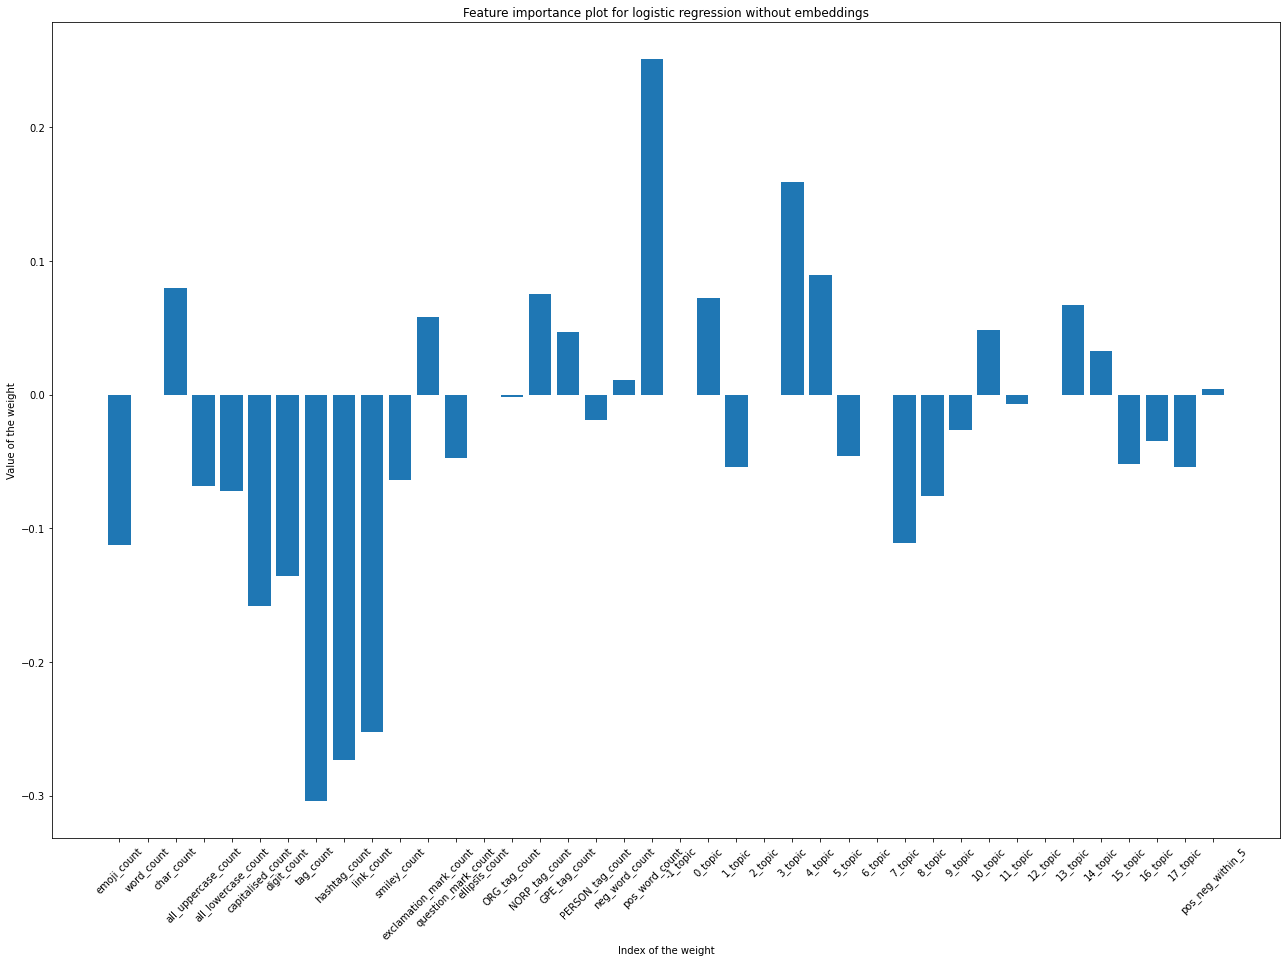

In [942]:
weights = pipeline_lr_best['lr'].coef_.flatten().tolist()
features = x_train.columns.tolist()

plt.figure(figsize=(22, 15))
plt.bar(features, weights)
plt.ylabel('Value of the weight')
plt.xlabel('Index of the weight')
plt.xticks(rotation = 45) 
plt.title('Feature importance plot for logistic regression without embeddings')
plt.show()

all_weights = []
all_weights.append(weights)

## Global best without topics

In [943]:
to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']
for i in range(300):
    to_drop.append(i)
to_drop.extend(topic_dummies)

x_train = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test = df_test.drop(columns=to_drop)

In [945]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__C': np.logspace(3, -9, 200),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6208536878920465
Best score: {'lr__C': 0.030018358135755922, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


In [946]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.650     0.574     0.609      1339
           1      0.613     0.686     0.647      1317

    accuracy                          0.629      2656
   macro avg      0.631     0.630     0.628      2656
weighted avg      0.631     0.629     0.628      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.653     0.617     0.634       561
           1      0.647     0.682     0.664       578

    accuracy                          0.650      1139
   macro avg      0.650     0.649     0.649      1139
weighted avg      0.650     0.650     0.649      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.714     0.622     0.664       473
           1      0.519     0.621     0.565       31

## Baseline classifiers for the first 4 topics

In [947]:
def get_train_validation_and_test_for_topic(topic_num, df_train, df_validation, df_test, features=baseline_features):
    df_train_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_validation_topic = df_validation[df_validation[f'{topic_num}_topic'] == 1]
    df_test_topic = df_test[df_test[f'{topic_num}_topic'] == 1]
    
    y_train = df_train_topic['Label']
    x_train = df_train_topic[features]

    y_validation = df_validation_topic['Label']
    x_validation = df_validation_topic[features]

    y_test = df_test_topic['Label']
    x_test = df_test_topic[features]
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [948]:
features_for_spec_topic = x_train.columns.tolist()
print(features_for_spec_topic)

['emoji_count', 'word_count', 'char_count', 'all_uppercase_count', 'all_lowercase_count', 'capitalised_count', 'digit_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'exclamation_mark_count', 'question_mark_count', 'ellipsis_count', 'ORG_tag_count', 'NORP_tag_count', 'GPE_tag_count', 'PERSON_tag_count', 'neg_word_count', 'pos_word_count', 'pos_neg_within_5']


## Best classifier and baseline for the 1st topic

In [949]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.584     0.590     0.587       575
           1      0.566     0.561     0.564       549

    accuracy                          0.576      1124
   macro avg      0.575     0.575     0.575      1124
weighted avg      0.576     0.576     0.576      1124
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.597     0.587     0.592       303
           1      0.535     0.545     0.540       264

    accuracy                          0.568       567
   macro avg      0.566     0.566     0.566       567
weighted avg      0.568     0.568     0.568       567
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.698     0.590     0.639       251
           1      0.495     0.612     0.547       16

In [950]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 300),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6236626984126984
Best score: {'lr__C': 0.8122673500479711, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [951]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.670     0.621     0.644       575
           1      0.631     0.679     0.654       549

    accuracy                          0.649      1124
   macro avg      0.650     0.650     0.649      1124
weighted avg      0.651     0.649     0.649      1124
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.630     0.634     0.632       303
           1      0.576     0.572     0.574       264

    accuracy                          0.605       567
   macro avg      0.603     0.603     0.603       567
weighted avg      0.605     0.605     0.605       567
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.713     0.681     0.697       251
           1      0.545     0.582     0.563       16

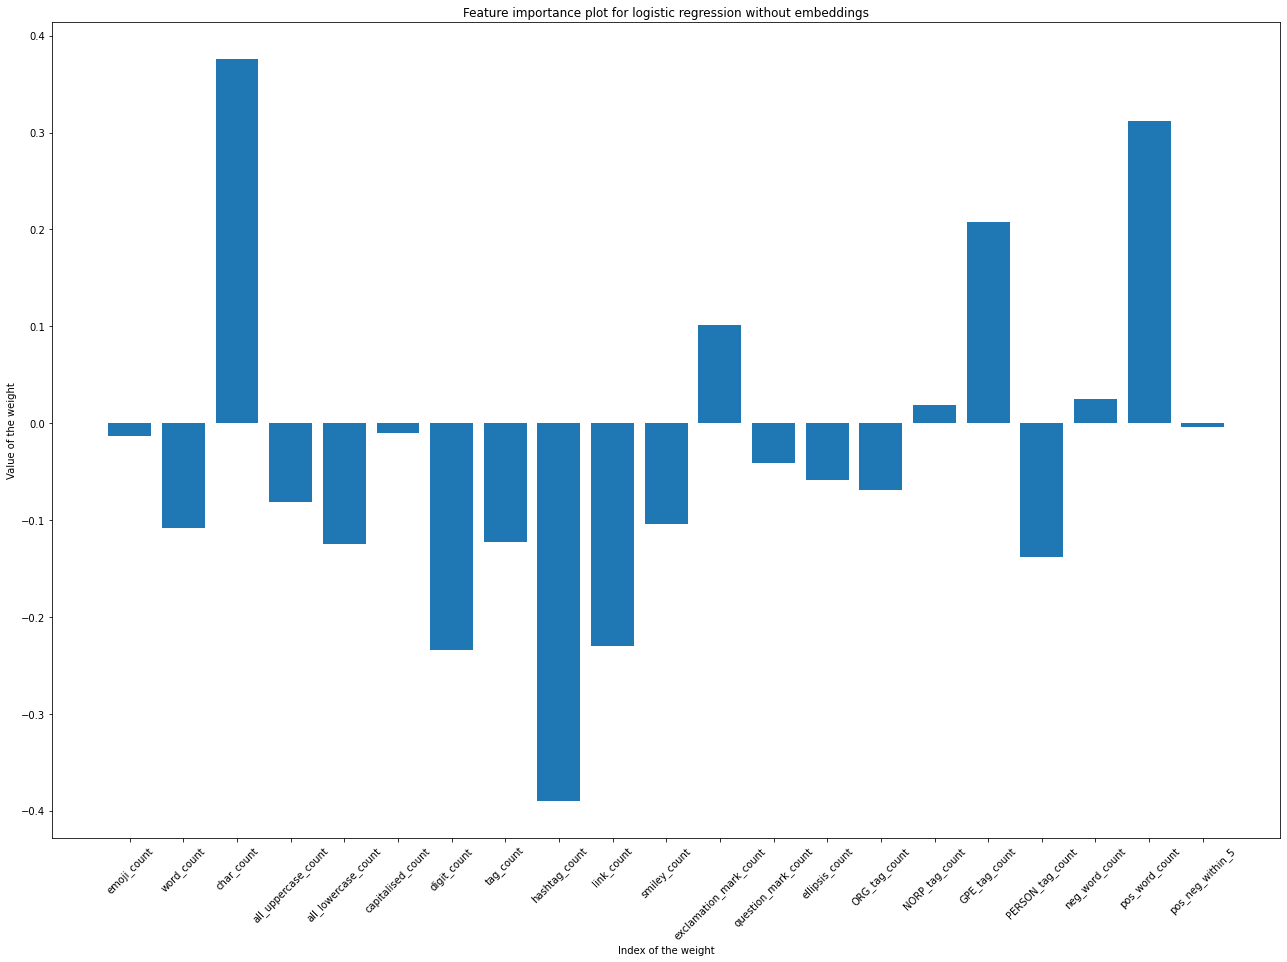

In [952]:
def plot_features(pipeline, features=features_for_spec_topic):
    weights = pipeline['lr'].coef_.flatten().tolist()
    all_weights.append(weights)
    plt.figure(figsize=(22, 15))
    plt.bar(features, weights)
    plt.ylabel('Value of the weight')
    plt.xlabel('Index of the weight')
    plt.xticks(rotation = 45) 
    plt.title('Feature importance plot for logistic regression without embeddings')
    plt.show()
    
plot_features(pipeline_lr_best)

## Best classifier for the 2nd topic

In [953]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.586     0.333     0.425       102
           1      0.583     0.798     0.674       119

    accuracy                          0.584       221
   macro avg      0.585     0.566     0.549       221
weighted avg      0.584     0.584     0.559       221
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.741     0.392     0.513        51
           1      0.617     0.877     0.725        57

    accuracy                          0.648       108
   macro avg      0.679     0.635     0.619       108
weighted avg      0.676     0.648     0.625       108
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.556     0.256     0.351        39
           1      0.463     0.758     0.575        3

In [954]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 300),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.5928282828282828
Best score: {'lr__C': 15.630754179458158, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [955]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.679     0.559     0.613       102
           1      0.672     0.773     0.719       119

    accuracy                          0.674       221
   macro avg      0.675     0.666     0.666       221
weighted avg      0.675     0.674     0.670       221
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.683     0.549     0.609        51
           1      0.657     0.772     0.710        57

    accuracy                          0.667       108
   macro avg      0.670     0.660     0.659       108
weighted avg      0.669     0.667     0.662       108
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.605     0.590     0.597        39
           1      0.529     0.545     0.537        3

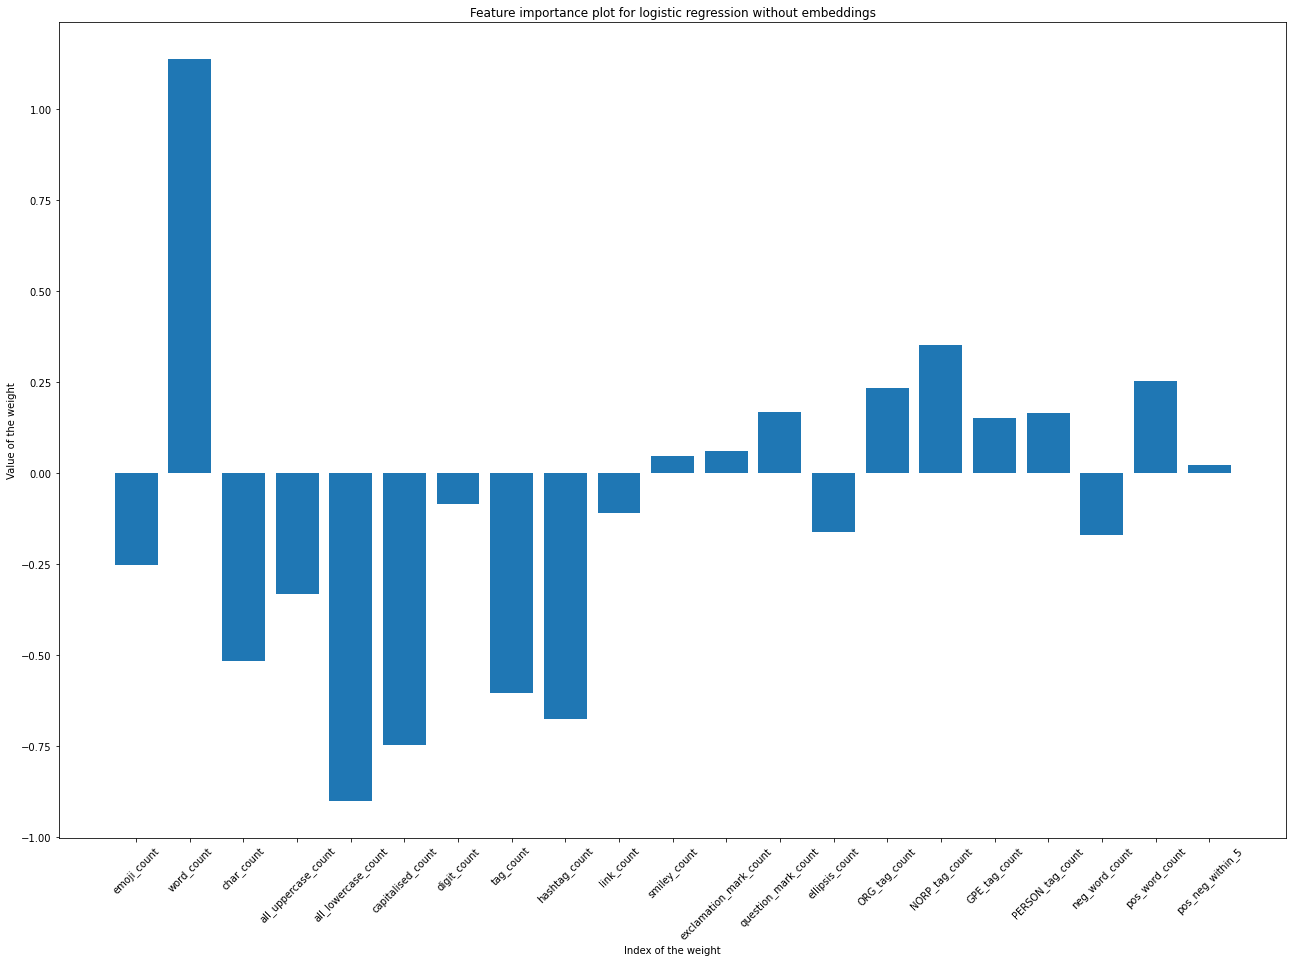

In [956]:
plot_features(pipeline_lr_best)

## Best classifier for the 3rd topic

In [957]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.667     0.838     0.743       105
           1      0.660     0.429     0.520        77

    accuracy                          0.665       182
   macro avg      0.663     0.633     0.631       182
weighted avg      0.664     0.665     0.648       182
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.622     0.719     0.667        32
           1      0.550     0.440     0.489        25

    accuracy                          0.596        57
   macro avg      0.586     0.579     0.578        57
weighted avg      0.590     0.596     0.589        57
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.630     0.654     0.642        26
           1      0.308     0.286     0.296        1

In [959]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 300),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6753753753753754
Best score: {'lr__C': 1000.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [964]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.765     0.838     0.800       105
           1      0.746     0.649     0.694        77

    accuracy                          0.758       182
   macro avg      0.756     0.744     0.747       182
weighted avg      0.757     0.758     0.755       182
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.633     0.594     0.613        32
           1      0.519     0.560     0.538        25

    accuracy                          0.579        57
   macro avg      0.576     0.577     0.576        57
weighted avg      0.583     0.579     0.580        57
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.560     0.538     0.549        26
           1      0.200     0.214     0.207        1

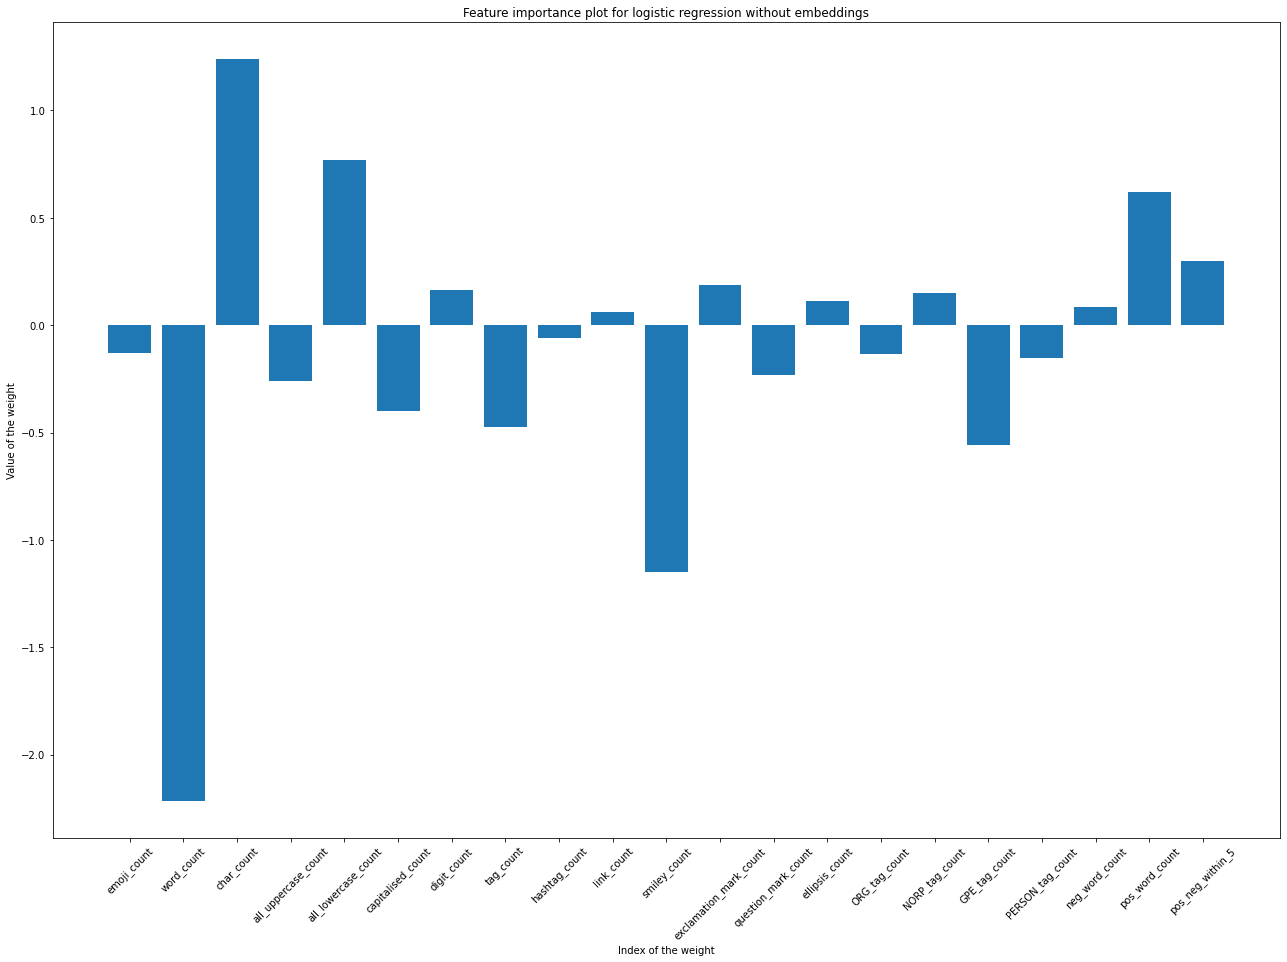

In [965]:
plot_features(pipeline_lr_best)

## Best classifier for the 4th topic

In [966]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.589     0.531     0.558        81
           1      0.568     0.625     0.595        80

    accuracy                          0.578       161
   macro avg      0.579     0.578     0.577       161
weighted avg      0.579     0.578     0.577       161
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.500     0.548     0.523        31
           1      0.548     0.500     0.523        34

    accuracy                          0.523        65
   macro avg      0.524     0.524     0.523        65
weighted avg      0.525     0.523     0.523        65
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.889     0.593     0.711        27
           1      0.389     0.778     0.519         

In [968]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 300),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6276515151515152
Best score: {'lr__C': 1.7012542798525891, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [969]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.714     0.679     0.696        81
           1      0.690     0.725     0.707        80

    accuracy                          0.702       161
   macro avg      0.702     0.702     0.702       161
weighted avg      0.702     0.702     0.702       161
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.636     0.677     0.656        31
           1      0.688     0.647     0.667        34

    accuracy                          0.662        65
   macro avg      0.662     0.662     0.661        65
weighted avg      0.663     0.662     0.662        65
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.950     0.704     0.809        27
           1      0.500     0.889     0.640         

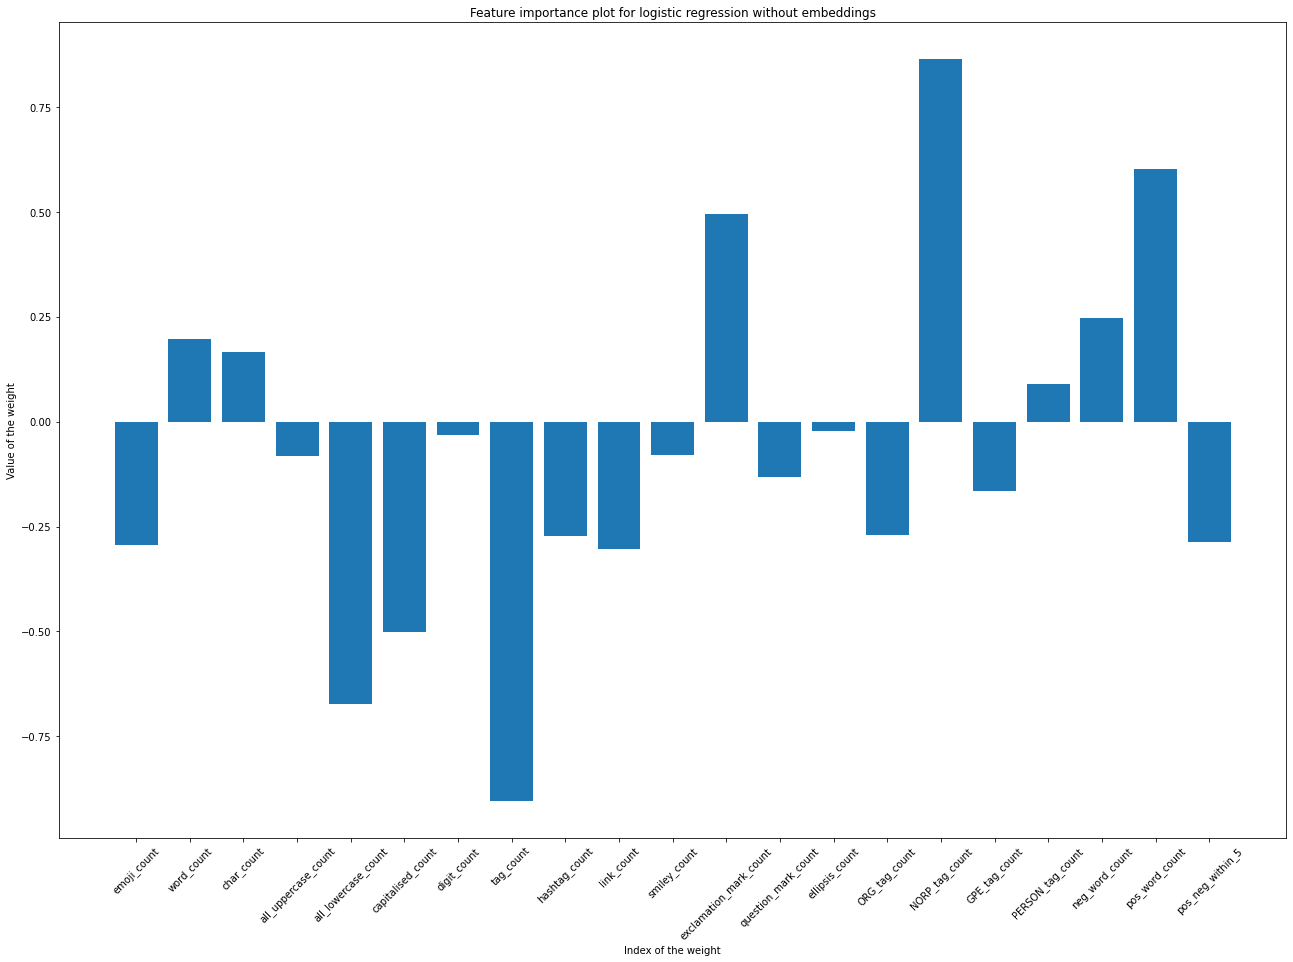

In [970]:
plot_features(pipeline_lr_best)

## Permutation test to determine whether topic affects (global)

In [974]:
from sklearn.model_selection import permutation_test_score
from mlxtend.evaluate import mcnemar, mcnemar_table, proportion_difference
from scipy.stats import t as t_dist
from sklearn.metrics import accuracy_score


to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']
for i in range(300):
    to_drop.append(i)


x_train_topics = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test_topics = df_test.drop(columns=to_drop)


bp1 = {'lr__C': 0.09115888299750818, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
bp2 = {'lr__C': 0.030018358135755922, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

# with topics
model_topics = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp1['lr__C'], penalty=bp1['lr__penalty'], solver=bp1['lr__solver']))
])
model_topics.fit(x_train_topics, y_train)


# without topics
model_no_topics = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp2['lr__C'], penalty=bp2['lr__penalty'], solver=bp2['lr__solver']))
])

to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']
for i in range(300):
    to_drop.append(i)
to_drop.extend(topic_dummies)

x_train_no_topics = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test_no_topics = df_test.drop(columns=to_drop)

model_no_topics.fit(x_train_no_topics, y_train)

y_pred_topics = model_topics.predict(x_test_topics)
y_pred_no_topics = model_no_topics.predict(x_test_no_topics)

print("McNemar's test")
table = mcnemar_table(y_target=y_test, y_model1=y_pred_topics, y_model2=y_pred_no_topics)
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

McNemar's test
chi² statistic: 1.0491803278688525, p-value: 0.30569594024383845



In [975]:
# First we fit the classification algorithms
model_topics.fit(x_train_topics, y_train)
model_no_topics.fit(x_train_no_topics, y_train)
# Generate the predictions
topics_y = model_topics.predict(x_test_topics)
no_topics_y = model_no_topics.predict(x_test_no_topics)
# Calculate the accuracy
acc1 = accuracy_score(y_test, topics_y)
acc2 = accuracy_score(y_test, no_topics_y)
# Run the test
print("Proportions Z-Test")
z, p = proportion_difference(acc1, acc2, n_1=len(y_test))
print(f"z statistic: {z}, p-value: {p}\n")

Proportions Z-Test
z statistic: 0.4699930494030549, p-value: 0.6808200082841345



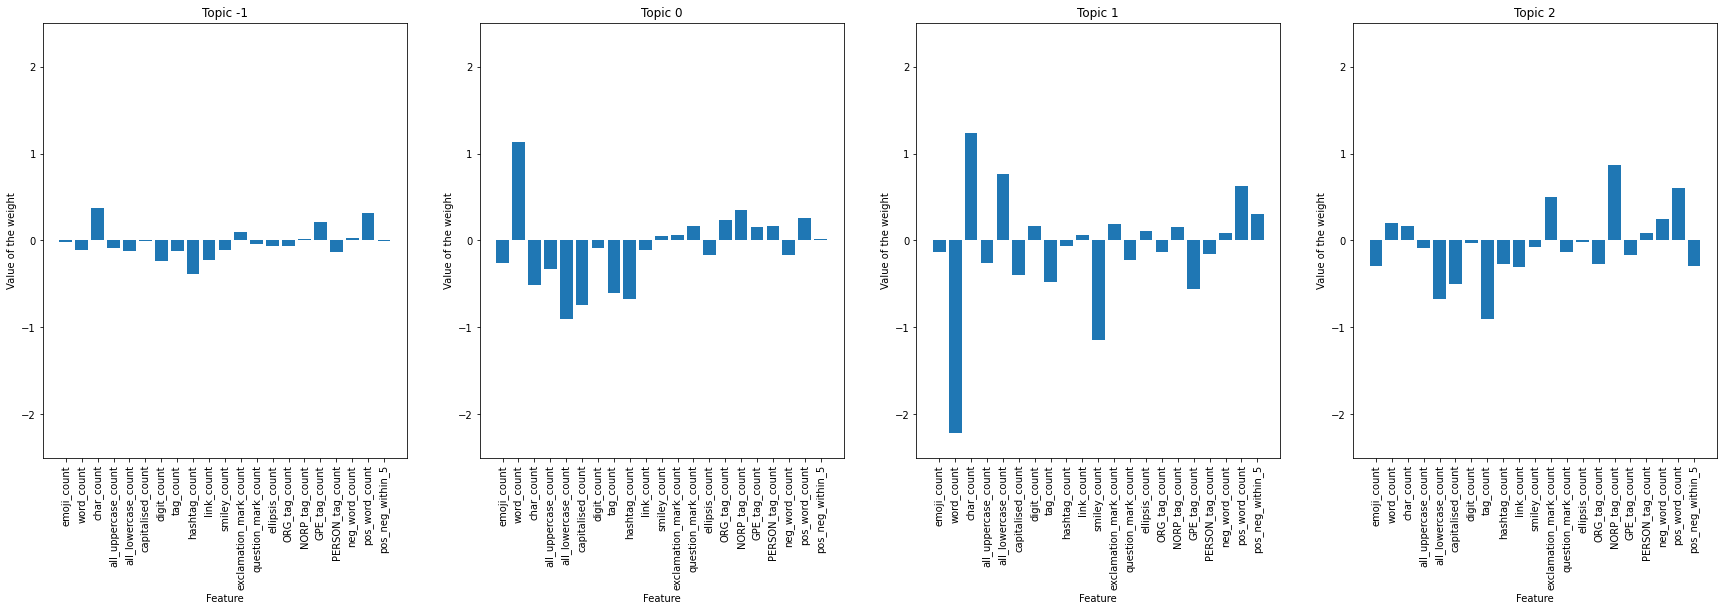

In [1017]:
all_weights_spec = all_weights[1:]
features_for_spec_topic

def plot_features_among_topics(all_weights_spec, features=features_for_spec_topic):
    plt.figure(figsize=(30, 8))
    for i in range(4):
        weights = all_weights_spec[i]
        plt.subplot(1, 4, i+1)
        plt.ylim([-2.5, 2.5])
        plt.bar(features, weights)
        plt.ylabel('Value of the weight')
        plt.xlabel('Feature')
        plt.xticks(rotation = 90)
        plt.title('Topic '+str(i-1))
        plt.plot()
    plt.savefig("importances.pdf", format="pdf", bbox_inches="tight")
    plt.show()

plot_features_among_topics(all_weights_spec)